<a href="https://colab.research.google.com/github/yue-zhongqi/cartpole_colab/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SC30000 Lab 1 Balancing a Pole on a Cart

## Installing dependencies:

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install tensorflow
!pip install moviepy

zsh:1: no matches found: gym[classic_control]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.2 MB/s eta 0:00:00a 0:00:010m
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.5.0
    Uninstalling setuptools-67.5.0:
      Successfully uninstalled setuptools-67.5.0
ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


## Importing dependencies and define helper functions

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
import time
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

# <font color='lightgreen'> Our implementation </font>

We selected the "Q Learning" model-free, off-policy reinforcement learning that will find the best course of action, given the current state of the agent. 


In [3]:
env = gym.make("CartPole-v1")

In [4]:
help(env)

Help on TimeLimit in module gym.wrappers.time_limit object:

class TimeLimit(gym.core.Wrapper)
 |  TimeLimit(env: gym.core.Env, max_episode_steps: Optional[int] = None)
 |  
 |  This wrapper will issue a `truncated` signal if a maximum number of timesteps is exceeded.
 |  
 |  If a truncation is not defined inside the environment itself, this is the only place that the truncation signal is issued.
 |  Critically, this is different from the `terminated` signal that originates from the underlying environment as part of the MDP.
 |  
 |  Example:
 |     >>> from gym.envs.classic_control import CartPoleEnv
 |     >>> from gym.wrappers import TimeLimit
 |     >>> env = CartPoleEnv()
 |     >>> env = TimeLimit(env, max_episode_steps=1000)
 |  
 |  Method resolution order:
 |      TimeLimit
 |      gym.core.Wrapper
 |      gym.core.Env
 |      typing.Generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, env: gym.core.Env, max_episode_steps: Optional[int] = Non

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [5]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [6]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [7]:
observation = env.reset()

print("Initial observations:", observation)

Initial observations: (array([ 0.03399039,  0.00384498, -0.01831256, -0.03022037], dtype=float32), {})


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

The **episode ends** if any one of the following occurs:<br>
**Termination**: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display) <br>
**Termination**: Pole Angle is greater than ±12° (±0.20944 rad)<br>
**Truncation**: Episode length is greater than 500.


In [8]:
# step(x): Choose an action (0 or 1)
observation, reward, terminated, truncated, info = env.step(1)

# Observation: Cart Position, Cart Velocity, Pole Angle, Pole Velocity At Tip
print("New observations after choosing action 0:", observation)

# Reward: 1 for every step taken, including the termination step
print("Reward for this step:", reward)

# Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
# Termination: Pole Angle is greater than ±12° (±0.20944 rad)
print("Is this round terminated?", terminated)

# Truncation: Episode length is greater than 500
print("Is this round truncated?", truncated)

New observations after choosing action 0: [ 0.03406729  0.1992247  -0.01891696 -0.3286244 ]
Reward for this step: 1.0
Is this round terminated? False
Is this round truncated? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [9]:
observation = env.reset()
cumulative_reward = 0
truncated = terminated = False

# Putting trunctated only will result in a 500 episode lenth before it terminates
print("\t\t\t\t\tCart Position, Cart Velocity, Pole Angle, Pole Velocity At Tip")

while not (truncated or terminated):
    observation, reward, terminated,truncated, info = env.step(0)
    print(f"New observations after choosing action {int(cumulative_reward)}:", observation)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)
print("Is this round terminated?", terminated)
print("Is this round truncated?", truncated)

					Cart Position, Cart Velocity, Pole Angle, Pole Velocity At Tip
New observations after choosing action 0: [ 0.02944337 -0.21630572 -0.04529868  0.24082842]
New observations after choosing action 1: [ 0.02511725 -0.4107523  -0.04048211  0.51888585]
New observations after choosing action 2: [ 0.01690221 -0.60528165 -0.03010439  0.79854226]
New observations after choosing action 3: [ 0.00479657 -0.7999779  -0.01413354  1.0816051 ]
New observations after choosing action 4: [-0.01120298 -0.9949105   0.00749856  1.3698195 ]
New observations after choosing action 5: [-0.03110119 -1.1901255   0.03489495  1.6648383 ]
New observations after choosing action 6: [-0.0549037  -1.3856356   0.06819171  1.9681822 ]
New observations after choosing action 7: [-0.08261642 -1.5814085   0.10755536  2.2811918 ]
New observations after choosing action 8: [-0.11424459 -1.7773509   0.1531792   2.6049674 ]
New observations after choosing action 9: [-0.1497916  -1.9732915   0.20527853  2.9402957 ]
New observat

## Task 1: Development of an RL agent

### Steps to construct our Q-Learning Algorithm: 

1. Create and define our Q table
    - A funciton to create a Q-Table
    - The function should return a tuple of the with bins of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.<br>
    

2. Conduct binning to create discrete intervals to faciliate discretisation of our continuous observation space. <br>

3. Convert the continuous state space using the user-defined function Discrete(state,bins) 

4. Define our Q-Learning Algorithm 

5. Train and define the RL agent

In [10]:
#PREPARATION
#Make the cartpole environment 
env = gym.make('CartPole-v1')
#Set our bin size to be 30 so that are are reasonably size intervals for discretisation
bin_size = 30

### Step 1: Create a Q-table 

- Our Q-table has rows containing all potential combinations of dicretised states and columns containing all possible actions. 

- Including all possible combinations of states and actions gives rise to a table shape of [bin_size] * state_space + [action_space] 
<br>--> which is [30 30 30 30 2] in our case as we have chosen bin size to be 30.

- Subsequently, this Q-table will be referenced to obtain Q-values that are indicators for the agent to determine the best action to be taken when it is in a particular state. 

- The agent would scan the Q-table for the highest Q-value or Q(s,a), and follow that action.

- The following is a simplified pictorial visualisation of our Q-table:  
![2023-02-28%2023.20.15.jpg](attachment:2023-02-28%2023.20.15.jpg)


If you are unable to view the image, click on this link: https://drive.google.com/file/d/1sEFHfRqSKNzjuImNIIxuggws1mHqh8lz/view?usp=sharing

In [11]:
#FUNCTION TO CREATE AND INITIALIZE Q-TABLE
def CreateQtable(state_space,action_space,bin_size):
    #Create our Q-table of size [30 30 30 30 2]
    #Initialize the entire table to 0 for to allow the agent to begin with randomness
    #After training, the agent will then update these Q-table entries to updated Q-values 
    #np.zeros(): returns an array of zeros with the passed in shape
    q_table = np.zeros(shape=([bin_size] * state_space + [action_space]))
    return q_table

#CREATE THE Q-TABLE 
q_table = CreateQtable(len(env.observation_space.low),env.action_space.n, bin_size) 

### Step 2: Binning 

- To ensure efficiency and functionality, the size of our Q-table is bounded time and space restrictions. <br> 

- This signifies that we are unable to cater to CartPole-v1's continuous observation space. Therefore, we have to create bins or pre-defined intervals in which every continuous state value can fall under. <br> 

- Such bins would help to facilitate the discretization of continous states into discrete states and enable us to create a reasonably-sized Q-table. <br> 

The following diagram describes how the binning process works: 
![2023-02-28%2023.20.21.jpg](attachment:2023-02-28%2023.20.21.jpg)

If you are unable to view the image, click on this link: https://drive.google.com/file/d/1C8HYvZc0jKHtKTguyVrQc6y2s4nBxaeB/view?usp=sharing

In [12]:
#FUNCTION TO CREATE BINS FOR EACH STATE (cart position, velocity and pole angle, angular velocity)
def CreateBins(bin_size): 
    #np.linspace(): returns evenly spaced numbers over a specified interval
    #syntax: np.linspace(start_val, end_val, num_of_samples_generated) 
    #We chose the start_val and end_val here to be the upper and lower limits for each state 
    bins = [np.linspace(-4.8,4.8,bin_size),
            np.linspace(-4,4,bin_size),
            np.linspace(-0.418,0.418,bin_size),
            np.linspace(-4,4,bin_size)]
    return bins 

#CREATE BINS 
bins = CreateBins(bin_size) 

### Step 3: Discretizing of continuous observation space

- To convert our continuous observation space into a discrete observation space, we made use of the np.digitize() function. <br> 

- The function helps us to categorise the states values into their respective bins according to the range in which their value falls into <br> 

The following diagram explains how np.digitize() works: 
![IMG_0419.jpg](attachment:IMG_0419.jpg)

If you are unable to view the image, click on this link: https://drive.google.com/file/d/103SX3hlmuZUlrBDVKRVyJemzqIDstJA-/view?usp=sharing

In [13]:
# Discretize the state
def Discrete(state, bins):

    index = []

    #np.digitize(): return the indices of the bins to which each value in input array belongs.
    #syntax: np.digitize(x, bins) -- where x = input array to be binned, bins = array of bins
    for i in range(len(state)): 
        index.append(np.digitize(state[i],bins[i]) - 1)

    return tuple(index)

### Step 4: Definining the Q-Learning Algorithm

- Firstly, the algorithm will begin by discretising the current state to facilitate searching up the Q-table thereafter 
- If the episode is neither terminated nor truncated, the agent proceeds to choose between exploring or exploiting the current Q-table under the Epsilon-Greedy policy 

The following explains the use of epsilon in our Q-Learning Algorithm: 
![2023-02-28%2023.20.18.jpg](attachment:2023-02-28%2023.20.18.jpg)

- The agent proceed to take the chosen action, discretize the next state and calculate the rewards earned


Then, we have to update the Q-table using the Temporal Difference formula : 

![2023-02-28%2023.20.10.jpg](attachment:2023-02-28%2023.20.10.jpg)


If you are unable to view the images, click on these links: 
- https://drive.google.com/file/d/1J7A6FEZ9TwVuwoH1SUw7yYRrQDFsRIZJ/view?usp=sharing
- https://drive.google.com/file/d/1kGrNWPjbeFVheQ5ca4f8GwrOPBUDs7ae/view?usp=share_link

#### Generating the Episodes

To actually generate the episodes, we use the Q_learning_algo() function, which uses different methods for when we're training the model, or testing it, this is done through the training parameter, where modification of the q_table is locked by the training parameter.

We evaluate only the next state, and we update the Q Table based on the reward achieved from generating the next state. 

In [14]:
#Generates an episode based on the current policy from the Q Table

def Q_learning_algo(q_table, bins, gamma, lr, epsilon, training):
        # initial observation
        current_state = Discrete(env.reset()[0],bins) 
        score = steps = 0
        terminated = truncated =  False
        
        while not (terminated or truncated):

            steps += 1 

            # Epsilon-greedy policy 
            if np.random.uniform(0,1) < epsilon and training == True: 
                # explore 
                action = env.action_space.sample()
            else: 
                # exploit 
                action = np.argmax(q_table[current_state])
            
            # Take action
            observation, reward, terminated, truncated, info = env.step(action)
            next_state = Discrete(observation,bins)

            score += reward

            # Update Q-Table if in training mode
            if (not (terminated or truncated)) and training == True:
                # Find the maximum Q-value for the next state
                max_future_q = np.max(q_table[next_state])
                # Get the current Q-value for the current state
                current_q = q_table[current_state+(action,)]
                # Calculate the new Q-value via Temporal Difference
                new_q = (1-lr)*current_q + lr*(reward + gamma*max_future_q)
                # Assign new Q-value to the Q-table
                q_table[current_state+(action,)] = new_q

            # Update the current state
            current_state = next_state
            
        if training == True:
            return q_table, score, steps
        else:
            return score, steps

### Step 5: Train and Define the Reinforcement Learning (RL) Agent 

- As the RL agent needs to learn from experience, we will train the agent by running the algorithm for 10000 episodes.
- We create a Q_learning function to run the algorithm for 10000 times and print out the result of when the problem is solved when the cumulative score for an episode exceeds 195.
- Due to the presence of an epsilon, the RL Agent will continuously explore and exploit such that the Q-table gradually contains values that are able to accurately "point out" optimal actions for the agent to take at every state 

In [15]:
def Q_learning(q_table, bins, episodes, gamma, lr, epsilon):

    rewards = 0
    steps = 0 
    runs = [0]
    solved = False
    
    for episode in range(episodes):
        
        q_table, score, steps = Q_learning_algo(q_table, bins, gamma, lr, epsilon, True)

        rewards += score
        runs.append(score)
        if score > 195 and steps >= 100 and solved == False: # considered as a solved:
            solved = True
            print('Solved in episode : {}'.format(episode))
            print("Episode, Steps, Score, Rewards: {}, {}, {}, {}".format(episode, steps, score, rewards))
            print("Terminated? {}, Truncated? {}".format(terminated, truncated))
   
    print('Training Complete')

env.close()


In [16]:
# Train the agent
Q_learning(q_table, bins, lr = 0.15, gamma = 0.995, episodes = 10*10**3, epsilon= 0.2)


Solved in episode : 936
Episode, Steps, Score, Rewards: 936, 298, 298.0, 29979.0
Terminated? True, Truncated? False
Training Complete


### For Task 1, we can show the observation and chosen action below:

Here we define a function that takes in the trained Q table, a given state space and the number of bins to return the optimal action using np.argmax to give the recommended action to take at a given discretized state.

In [17]:
def q_policy_agent(observation, q_table, bins):
    return np.argmax(q_table[Discrete(observation,bins)])

In [18]:
observation = env.reset()
action = q_policy_agent(observation[0], q_table, bins)
print("Observation:", observation)
print("Chosen action:", action)

Observation: (array([ 0.03833739,  0.04062668, -0.01455519, -0.00846346], dtype=float32), {})
Chosen action: 1


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

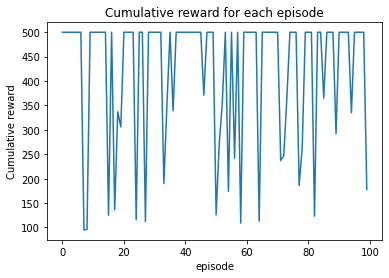

In [19]:
# Test the agent
episode_results = {'episode':[],'rewards':[]}

for i in range(100):
    rewards = 0
    episode = 1
    score, steps = Q_learning_algo(q_table, bins, 0, 0, 0, False)
    rewards += score
    episode += 1
    # Update the score
    episode_results['rewards'].append(rewards)
    episode_results['episode'].append(episode)


plt.plot(episode_results['rewards'])
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()


Print the average reward over the 100 episodes.

In [20]:
print("Average cumulative reward:", np.array(episode_results['rewards']).mean())
print("Is my agent good enough?", np.array(episode_results['rewards']).mean() > 195)

Average cumulative reward: 420.58
Is my agent good enough? True


## Task 3: Render one episode played by the agent

In [21]:
env = RecordVideo(gym.make("CartPole-v1",render_mode = "human"),"./video")
# run for 10 episodes

for episode in range(5):
  step = 0
  print("EPISODE:",episode+1)
  observation = env.reset()
  observation = observation[0]
  print(observation)
  while True:
      step +=1 
      env.render()
      #your agent goes here
      action = q_policy_agent(observation,q_table,bins)
      observation, reward, terminated,truncated, info = env.step(action) 
      if (terminated or truncated):
        print("Ended in step:",step)
        break

env.close()
show_video()

EPISODE: 0
[-0.04737634  0.03208195 -0.03601972 -0.026943  ]
Ended in step: 500
EPISODE: 1
[-0.01017627  0.03611155  0.03823334  0.04705787]
Ended in step: 372
EPISODE: 2
[0.00900298 0.00800848 0.03736914 0.04811892]
Ended in step: 500
EPISODE: 3
[-0.03951471  0.02558847 -0.01298073 -0.00406908]
Ended in step: 185
EPISODE: 4
[ 0.02461655 -0.03658116 -0.02146005  0.04361316]
Ended in step: 336
Could not find video
